In [60]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from itertools import product
from scipy.stats import wilcoxon, shapiro, ttest_rel
import itertools

from tqdm import tqdm
from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl

2025-12-08


In [2]:
workdir = '/mnt/disk7t/xwj/axolotl_rev'
datasetdir = f'{workdir}/dataset_nc2017kremer'

os.chdir(datasetdir)
# level 1
output_path = f'{workdir}/result/dataset_nc2017kremer'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

In [28]:
from sklearn.metrics import auc
import pandas as pd
import numpy as np

## precision recall curve add segments for easy plotting
n_seg = 1000
recall_seg = np.linspace(0, 1, num=n_seg+1)

def sort_only_score_auprc(res_data, score_col, df_outlier): 
    # for ABEILLE只对score排序，回答审稿人对ABEILLE bad质疑
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[  score_col], ascending=[ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1

    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]

def sort_label_score_auprc(res_data, class_col, score_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank',class_col, score_col]].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1

    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]


## 定义函数来计算AUPRC
def pred_outlier_auprc(res_data, df_outlier):
    
    res_data.index.name = 'Gene'
    res_data.columns.name = 'Sample'
    res_data = res_data.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
    sorted_data = res_data.sort_values(by='pred',ascending=True)
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)
    # 准备PR曲线数据
    pr_curve = sorted_data[['rank','pred']].copy() # 保存pred值用于绘图20251201回答审稿人ABEILLE bad质疑
    pr_curve['label'] = 0
    
    for i, row in df_outlier.iterrows(): 
    #     print(i,row['Gene'],row['Sample'])
        pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
    pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

    # auprc value
    auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
    # save a simple curve for plotting
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    # keep equally distributed points 
    idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
    return auprc, pr_curve.loc[idx,]


# 定义方法和打分方式的对应关系
methods_scores = {
    'ABEILLE': ['predict', 'anomaly_score', 'delta_count', 'divergence_score'],
    'OUTRIDER': ['aberrant', 'pValue', 'zScore','padjust']
}
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'pValue', 'zScore','padjust']


# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}

use = 't00_FB_s119_g11048' # all genes have minreads 1, subset random set from here
# use = 't00_FB_s119_g14409'
tissues = pd.read_csv(f'tissues_{use}.tsv', sep='\t', index_col=0)

tissues

,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,FB,Fibroblast,119,11048,/mnt/disk7t/xwj/axolotl_rev/dataset_nc2017krem...,/mnt/disk7t/xwj/axolotl_rev/dataset_nc2017krem...


In [11]:
# for i, row in tissues.iterrows():
    
#     t  = row.TISSUE_ID
#     tn = row.TISSUE_NAME
#     ns = row.N_SAMPLE
#     ng = row.N_GENE
#     ctsfile = row.CTS_FILE
#     outlierfile = row.OUTLIER_FILE
# print(outlierfile)

use = 't00_FB_s119_g11048'
tissues = pd.read_csv(f'tissues_{use}.tsv', sep='\t', index_col=0)
tissue_data = tissues.iloc[0]
t = tissue_data[0]  # TISSUE_ID
tn = tissue_data[1]  # TISSUE_NAME
ns = tissue_data[2]  # N_SAMPLE
ng = tissue_data[3]  # N_GENE
ctsfile = tissue_data[4]  # CTS_FILE
outlierfile = tissue_data[5]  # OUTLIER_FILE

cts = pd.read_csv(ctsfile, sep='\t', index_col=0)

base_prefix = f't01_{t}_s{ns}_g{ng}_nmd' # Version2.  six valid + equal number of NMD, must in sub samples
output_file = os.path.join(task_config_path, f'{base_prefix}_sampled_configs_dict.pkl')
sampled_configs = pickle.load(open(output_file, 'rb'))

In [154]:
cts.index.name, cts.columns.name

('Gene', None)

In [37]:
# output_file = '/mnt/disk7t/xwj/axolotl_rev/result/dataset_nc2017kremer/task_config/t00_FB_s119_g11048_sampled_configs_dict.pkl'
output_file = f'{task_config_path}/t01_FB_s119_g11048_nmd_sampled_configs_dict.pkl'
name_prefix = 't01_FB_s119_g11048_nmd'
sampled_configs = pickle.load(open(output_file, 'rb'))

# outliers_used = pd.read_csv(f'{datasetdir}/outlier_RNAID_sg28.tsv', sep= '\t') 
outliers_used = pd.read_csv(outlierfile, sep='\t',index_col=0)


## sample sizes 10~100

In [ ]:

# 定义方法和打分方式的对应关系
methods_scores = {
    # 'OUTRIDER': ['aberrant', 'pValue','padjust', 'zScore',],
    'OUTRIDER': ['aberrant', 'padjust',],
    'ABEILLE': ['predict', 'anomaly_score', 'delta_count', 'divergence_score'],
}
outrider_scores = [ 'padjust',]
abl_scores = [ 'anomaly_score', 'delta_count', 'divergence_score']

print(outrider_scores, abl_scores)
# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True
}
rank_types = ['table','sample']
# 创建多级索引，包含样本量和重复信息

n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates)  # 使用0-9作为随机种子

sample_sizes = [ 10, 30, 60, 100, ]# [100, 60, 30, 10]
baselines = [ 'ABEILLE','OUTRIDER', 'OUTSINGLE',] #[  'OUTRIDER', 'OUTSINGLE',]
mymethods = ['f0.1L20']
methods = baselines + mymethods
# 填充数据
for size in sample_sizes:
    
    dict_res = dict() # size
    dict_auprc = dict()
    dict_curve = dict()
    
    for seed in range(n_replicates):
        k = seed
        dict_res[k] = dict() # 10 seeds 
        dict_auprc[k] = dict()
        dict_curve[k] = dict()
        # 获取当前抽样的配置
        current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
        task_config = current_config['config']
        # df_sample = pd.read_csv(task_config['samples'].values[0], index_col='task',sep='\t')
        # samples_used = df_sample.loc[0]
        samples_used = current_config['selected_samples']
        df_outlier = outliers_used.query('(Sample in @samples_used)')
        
        for m in methods:
            # ==> level 3. (tissue, task, method)
            print(size, seed, m)
            dict_res[k][m]= dict()
            for j,row in task_config.iterrows():                    
                #----------- 调用函数auprc
                # print(df_outlier.head())
                
                if m == 'ABEILLE':
                    
                    df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                    df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                    class_col = 'predict'
                    
                    # samples_used = df_pred['Sample'].unique().tolist()
                    # df_outlier = outliers_used.query('(Sample in @samples_used)')
                    # print(df_outlier.shape, len(samples_used))
        
                    for score in abl_scores:
                        dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                        dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                
                elif m == 'OUTRIDER':
                    
                    df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                    df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                    class_col = 'aberrant'
                    # samples_used = df_pred['sampleID'].unique().tolist()
                    # df_outlier = outliers_used.query('(Sample in @samples_used)')
                    # print(df_outlier.shape, len(samples_used))
                    
                    for score in outrider_scores: # score = 'pValue'
                        dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                        dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                
                elif m == 'OUTSINGLE':
                    
                    df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                    # samples_used = df_pred.columns.tolist()
                    # df_outlier = outliers_used.query('(Sample in @samples_used)')
                    # print(df_outlier.shape, len(samples_used))
                    
                    dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                    dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)
                    
                else:
                    df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                    # samples_used = df_pred.columns.tolist()
                    # df_outlier = outliers_used.query('(Sample in @samples_used)')
                    # print(df_outlier.shape, len(samples_used))
                    
                    dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                    dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)                    
                    
                    # df_outlier = outliers_used.query('Sample in @df_pred.columns') 
                            
    file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
    outputdata = [ t, tn, i, dict_auprc, dict_curve ]
    import pickle
    with open(file, 'wb') as f: 
        pickle.dump( outputdata,  f )
    break

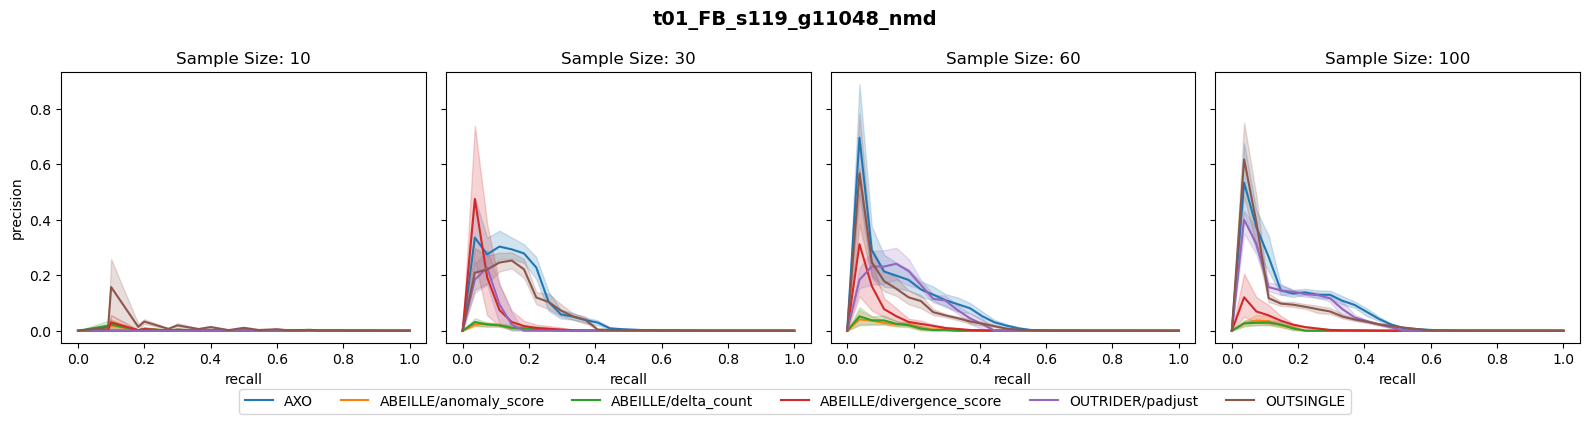

In [108]:
auprc_data_for_boxplot = dict()

# 非空的元素
draw_methods = [
    'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
    ]
plt.style.use('default')
fig, axes = plt.subplots(1, len(sample_sizes), figsize=(4*len(sample_sizes), 4), sharey=True )
# auprc = pd.DataFrame(index=sample_sizes, columns=draw_methods)
myindex = pd.MultiIndex.from_tuples([ (size, k) for size in sample_sizes for k in range(n_replicates) ],names=['size', 'seed'])
auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32) 

sample_sizes = [ 10, 30,  60, 100, ]# [100, 60, 30, 10]

for i, size in enumerate(sample_sizes):
    # t  = row.TISSUE_ID
    # tn = row.TISSUE_NAME
    
    # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl' # 改成需要的后缀 OUTRIDER_dim!
    file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
    with open(file,'rb') as f:
        data_load = pickle.load(f)
    _t, _tn, _i, dict_auprc, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
    
    for k in range(n_replicates):
        auprc.loc[(size, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]

    # k = 'all'
    # print(t, tn, i,file)

    required_sets = 1
    draw = \
    pd.concat([
    pd.concat( [ 
        pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                axis=0, keys= range(required_sets)).drop_duplicates(subset=['label', 'precision', 'recall']).reset_index(drop=True)
        for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
    for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep']).rename(index={ 'f0.1L20':'AXO'})

    # sns.lineplot(data=draw, x="recall", y="precision", hue="method", palette='tab10', ax= axes[i])
    sns.lineplot(
        data=draw,
        x="recall",
        y="precision",
        hue="method",
        palette='tab10',
        ax=axes[i],
        errorbar=('ci', 95),  # 90%置信区间
        n_boot=100,  # bootstrap采样次数
        alpha=1,
    )
    axes[i].set_title(f'Sample Size: {size}')

    axes[i].get_legend().remove()

# 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels,
        loc='center',           # 居中
        bbox_to_anchor=(0.5, 0),  # 放在底部（微调 0.02）
        ncol=len(labels),       # 横向排列
        frameon=True)


# 给图例留一点底部空间
fig.subplots_adjust(bottom=0.2)
fig.suptitle(name_prefix, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/kremer_prcurve_sizes10-100.pdf',dpi=200, bbox_inches='tight')
# tissuse_title = f't{i:02d}_{t}_s{ns}_g{ng}'
auprc_data_for_boxplot[name_prefix] = auprc


In [100]:
auprc = auprc.rename(columns={'f0.1L20':'AXO'})

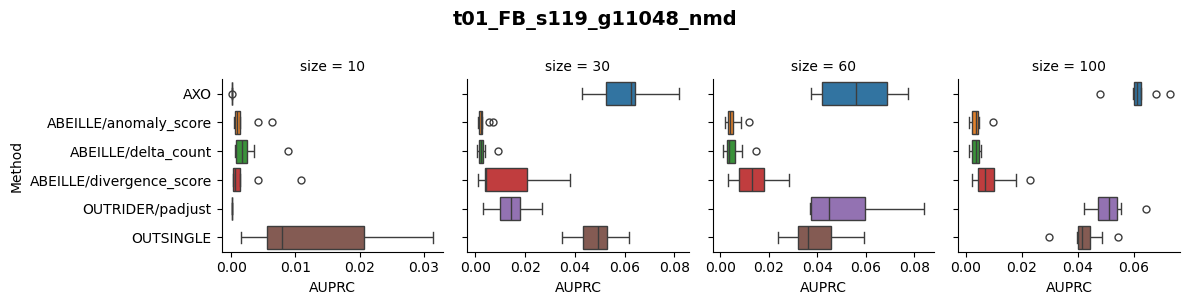

In [101]:
auprc_long = auprc.stack().reset_index(name='AUPRC').rename(columns={'level_2':'Method'})

g = sns.catplot( auprc_long, kind='box', y = 'Method', x='AUPRC', hue='Method', col='size', 
            orient='h', palette='tab10', sharex=False, height=3, aspect=1)
g.fig.suptitle(name_prefix, y=1, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/kremer_box_auprc_sizes10-100.pdf',dpi=200)

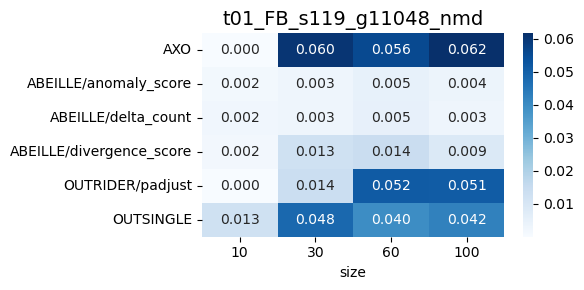

In [102]:
draw = auprc.groupby(level=['size']).mean().T
fig, axes = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
sns.heatmap(
    draw,
    annot=True,
    cmap='Blues',
    fmt='.3f',
    ax=axes,
)
axes.set_title(f'{name_prefix}', fontsize=14)
plt.tight_layout()

In [103]:
# p-value
auprc_all_sizes = auprc.astype(np.float32).copy()

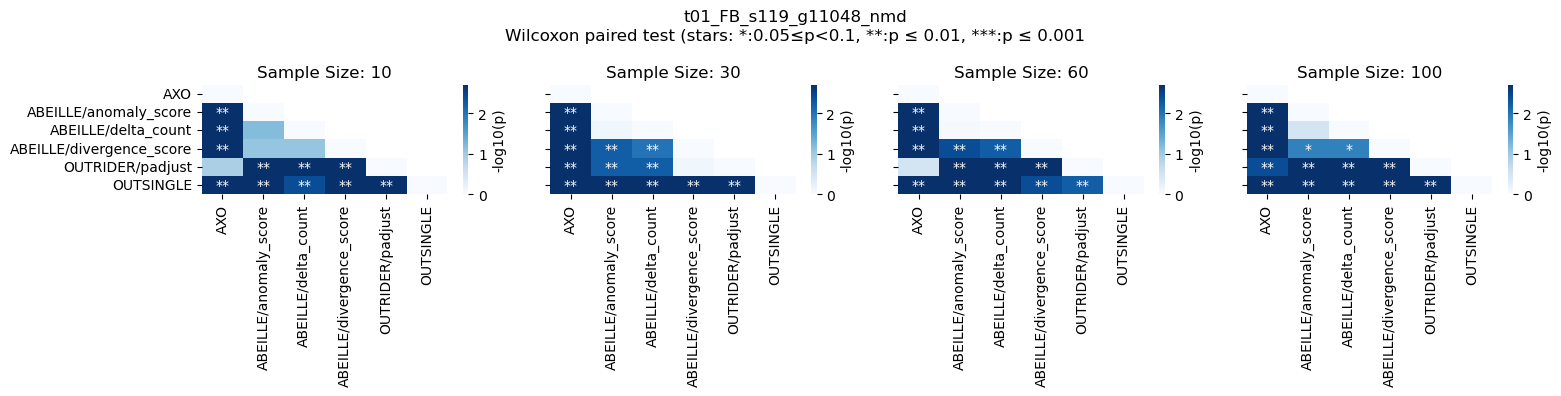

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(1, len(sample_sizes), figsize=(4*len(sample_sizes), 4), sharey=True, sharex=True)

for size in sample_sizes:
    auprc = auprc_all_sizes.query('size == @size').droplevel('size')
    columns = auprc.columns.tolist()
    results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

    for method1, method2 in itertools.combinations(columns, 2):
        x = auprc[method1].dropna()
        y = auprc[method2].dropna()
        
        # make they are same length
        min_len = min(len(x), len(y))
        x = x.iloc[:min_len]
        y = y.iloc[:min_len]
        
        # wilcoxon test
        alternative = 'two-sided'
        stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

        new_row = pd.DataFrame({
            'Method1': [method1],
            'Method2': [method2],
            'Statistic': [stat],
            'p-value': [p_value]
        })
        
        results = pd.concat([results, new_row], ignore_index=True)

    axo_results = results#.query('(Method1 not in @baselines) and (Method2 not in @baselines)')
    # ---- 1. 对称矩阵化 ----
    pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
    pivot = pivot.combine_first(pivot.T)        # 补全下三角
    np.fill_diagonal(pivot.values, 1)           # 对角=1
    
    pivot = pivot.loc[columns, columns] # use the meothds order in auprc
    # ---- 2. -log10 变换 ----
    log_p = -np.log10(pivot)
    log_p = log_p.replace([np.inf, -np.inf], np.nan)

    # ---- 3. 三角掩码 ----
    mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

    def p2star(p):
        if pd.isna(p) or p > 0.05:
            return ''
        elif p <= 1e-4:
            return '****'
        elif p <= 1e-3:
            return '***'
        elif p <= 1e-2:
            return '**'
        else:
            return '*'

    # 1. 星号对称矩阵（同索引）
    star_mat = pivot.applymap(p2star)

    # ---- 4. 画图 ----
    # plt.figure(figsize=(10, 5))
    sns.heatmap(log_p,
                mask=mask,
                cmap='Blues',
                annot=star_mat,
                fmt='',
                cbar_kws={'label': '-log10(p)'}, ax=axes[sample_sizes.index(size)])
    # axes[sample_sizes.index(size)].set_xticklabels(axes[sample_sizes.index(size)].get_xticklabels(), rotation=90)
    axes[sample_sizes.index(size)].set_title(f'Sample Size: {size}')

plt.suptitle(f'{name_prefix}\nWilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/kremer_heatmap_auprc_sizes10-100_wilcox_p_star.pdf',dpi=200)

## change percentage of outliers at sample sizes 50 & 100

In [ ]:
# level 1
output_path = f'{workdir}/result/dataset_nc2017kremer'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

list_outlier_pct = [ 0.08, 0.16, 0.24,]
sample_sizes = [100, 50,]

# subsetting file
use = 't00_FB_s119_g11048' # all genes have minreads 1, subset random set from here

tissues = pd.read_csv(f'tissues_{use}.tsv', sep='\t', index_col=0)
 
# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE
    ctsfile = tissue_data['CTS_FILE']  # CTS_FILE
    outlierfile = tissue_data['OUTLIER_FILE']  # OUTLIER_FILE
    
    # positive samples
    outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
    outlier = outlier.drop_duplicates('Sample').copy()
    assert outlier['Sample'].size == len(set(outlier['Sample']))
    
    outliers_used = outlier.copy()
    
    for pct in list_outlier_pct: # 增加pct的变化
        # 创建基础前缀
        name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}_pct{pct:.2f}'
        print(name_prefix)
        output_file = f'{task_config_path}/{name_prefix}_sampled_configs_dict.pkl'
        sampled_configs = pickle.load(open(output_file, 'rb'))

        for size in sample_sizes:
            
            dict_res = dict() # size
            dict_auprc = dict()
            dict_curve = dict()
            
            for seed in range(n_replicates):
                k = seed
                dict_res[k] = dict() # 10 seeds 
                dict_auprc[k] = dict()
                dict_curve[k] = dict()
                # 获取当前抽样的配置
                current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
                task_config = current_config['config']
                # df_sample = pd.read_csv(task_config['samples'].values[0], index_col='task',sep='\t')
                # samples_used = df_sample.loc[0]
                samples_used = current_config['selected_samples']
                df_outlier = outliers_used.query('(Sample in @samples_used)')
                
                for m in methods:
                    # ==> level 3. (tissue, task, method)
                    print(size, seed, m, pct)
                    dict_res[k][m]= dict()
                    for j,row in task_config.iterrows():                    
                        #----------- 调用函数auprc
                        # print(df_outlier.head())
                        
                        if m == 'ABEILLE':
                            
                            df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                            df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                            class_col = 'predict'
                            
                
                            for score in abl_scores:
                                dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                                dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                        
                        elif m == 'OUTRIDER':
                            
                            df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                            df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                            class_col = 'aberrant'

                            
                            for score in outrider_scores: # score = 'pValue'
                                dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                                dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                        
                        elif m == 'OUTSINGLE':
                            
                            df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)

                            
                            dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                            dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)
                            
                        else:
                            df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)

                            
                            dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                            dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)                    
                            
                            # df_outlier = outliers_used.query('Sample in @df_pred.columns') 
                                    
            file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
            outputdata = [ t, tn, i, dict_auprc, dict_curve ]

            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )
                    


t00_FB_s119_g11048_pct0.08
50


/tmp/ipykernel_13252/2557553766.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]


100


/tmp/ipykernel_13252/2557553766.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]


t00_FB_s119_g11048_pct0.16
50


/tmp/ipykernel_13252/2557553766.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]


100
t00_FB_s119_g11048_pct0.24


/tmp/ipykernel_13252/2557553766.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]


50
100


/tmp/ipykernel_13252/2557553766.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]
/tmp/ipykernel_13252/2557553766.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]


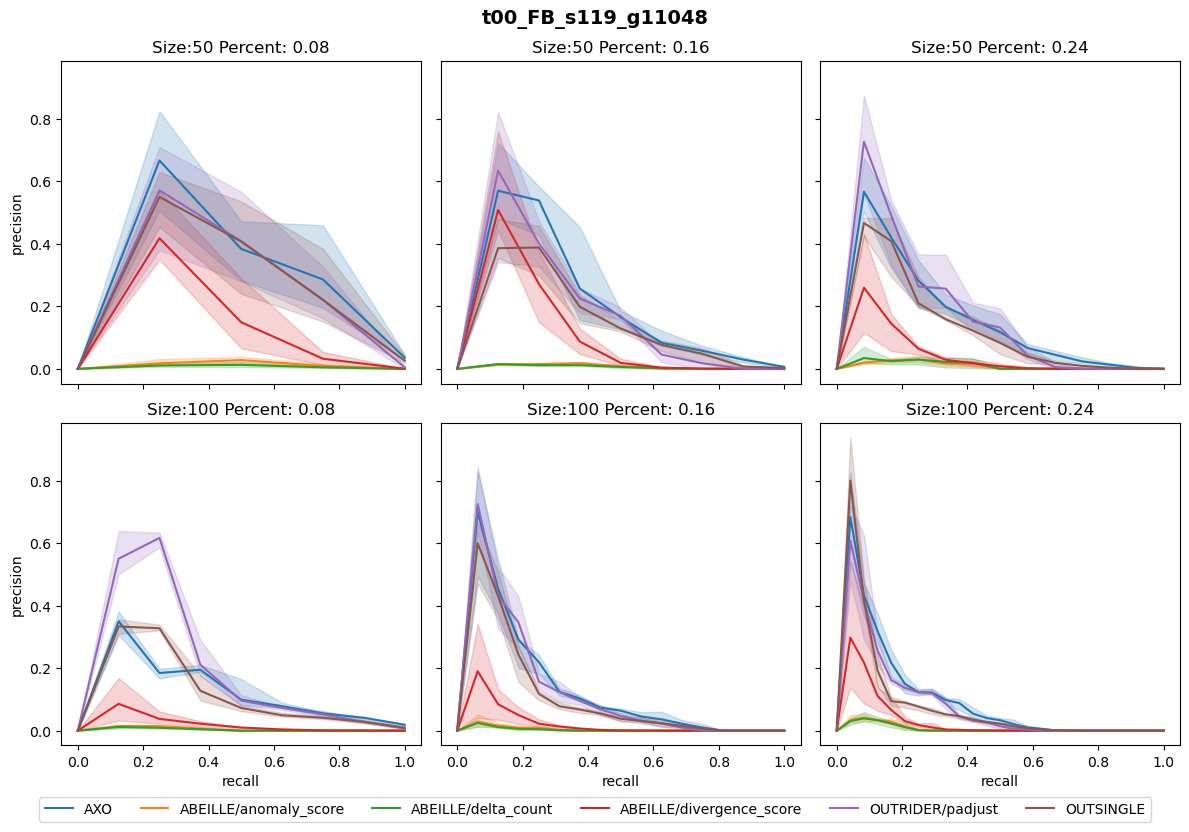

In [ ]:
draw_methods = [
    'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
    ]
auprc_data_for_boxplot = dict()
# 从tissues中获取信息

for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    fig, axes = plt.subplots(len(sample_sizes), len(list_outlier_pct), figsize=(4*len(list_outlier_pct), 4*len(sample_sizes)), sharey=True, sharex=True)
    myindex = pd.MultiIndex.from_tuples([ (size, pct, k) for size in sample_sizes for pct in list_outlier_pct for k in range(n_replicates) ],
                                        names=['size', 'pct', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)
    
    # 创建基础前缀
    for ax_i, pct in enumerate(list_outlier_pct): # 增加pct的变化
        # 创建基础前缀
        name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}_pct{pct:.2f}'
        print(name_prefix)

        for ax_j, size in enumerate(np.sort(sample_sizes)):
            print(size)
            # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl'
            file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
            with open(file,'rb') as f:
                data_load = pickle.load(f)
            _t, _tn, _i, dict_auprc, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
            
            for k in range(n_replicates):
                auprc.loc[(size, pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]
                
            required_sets = 1
            draw = \
            pd.concat([
            pd.concat( [ 
                pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                        axis=0, keys= range(required_sets)).drop_duplicates(subset=['label', 'precision', 'recall']).reset_index(drop=True)
                for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
            for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep']).rename(index={ 'f0.1L20':'AXO'})
                
            sns.lineplot(
                data=draw,
                x="recall",
                y="precision",
                hue="method",
                palette='tab10',
                ax=axes[ax_j, ax_i],
                errorbar=('ci', 95),  # 90%置信区间
                n_boot=10,  # bootstrap采样次数
                alpha=1,
            )
            axes[ax_j,ax_i].set_title(f'Size:{size} Percent: {pct}')
                # 1. 去掉子图自己的图例
            axes[ax_j,ax_i].get_legend().remove()

    # 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
    handles, labels = axes[ax_j, -1].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5, 0.02),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)

    plt.tight_layout()
    # 给图例留一点底部空间
    fig.subplots_adjust(bottom=0.1)
    tissuse_title = f't{i:02d}_{t}_s{ns}_g{ng}'
    fig.suptitle(tissuse_title, y=1.02, fontsize=14, fontweight='bold')
    plt.savefig(f'{workdir}/result/figure/kremer_prcurve_sizes50-100_pct.pdf',dpi=200, bbox_inches='tight')
    # 保存，用于画 boxplot
    auprc_data_for_boxplot[tissuse_title] = auprc.rename(columns={ 'f0.1L20':'AXO'})


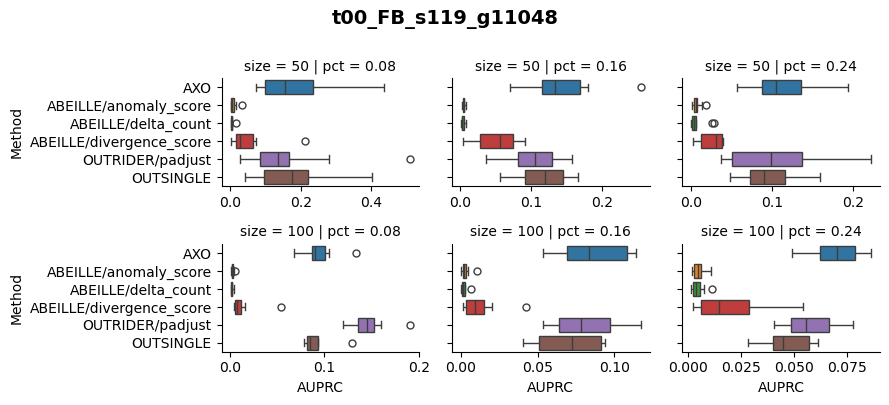

In [124]:

for name_prefix, auprc in auprc_data_for_boxplot.items():
    auprc_long = auprc.stack().reset_index(name='AUPRC').rename(columns={'level_3':'Method'})
    
    g = sns.catplot( auprc_long, kind='box', y = 'Method', x='AUPRC', hue='Method', col='pct', row='size',
                orient='h', palette='tab10', sharex=False, height=2, aspect=1.5)
    g.fig.suptitle(name_prefix, y=1, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/kremer_box_auprc_sizes50-100_pct.pdf',dpi=200,)

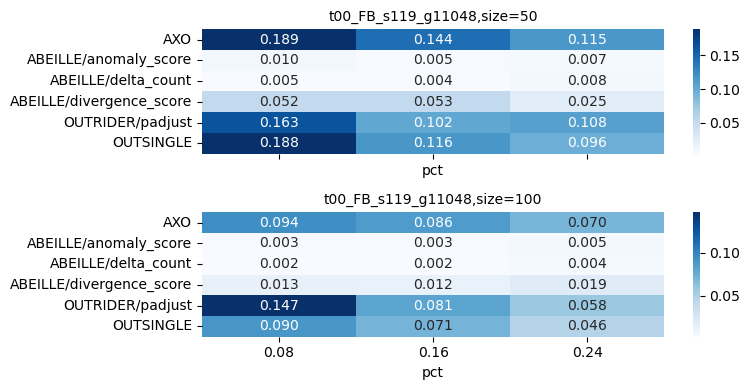

In [131]:
n_col = len(auprc_data_for_boxplot)
n_row = len(sample_sizes)
fig, axes = plt.subplots(n_row, n_col, figsize=(8, 2*n_row), sharex=True)

for i, (name_prefix, auprc) in enumerate(auprc_data_for_boxplot.items()):
    
    for j, size in enumerate(np.sort(sample_sizes)):
        draw = auprc.query('size == @size').groupby(level=['size','pct']).mean().T
        draw = draw.droplevel('size',axis='columns')
        if n_col == 1:
            ax = axes[j]
        else:
            ax = axes[j,i]
        sns.heatmap(
            draw,
            annot=True,
            cmap='Blues',
            fmt='.3f',
            ax=ax,
        )
        ax.set_title(f'{name_prefix},size={size}', fontsize=10)
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/kremer_heatmap_auprc_sizes50-100_pct.pdf',dpi=200,)

In [141]:
for name_prefix, auprc in auprc_data_for_boxplot.items():
    print(name_prefix)
    auprc_all_sizes = auprc.astype(np.float32).copy()

t00_FB_s119_g11048


In [ ]:
# 

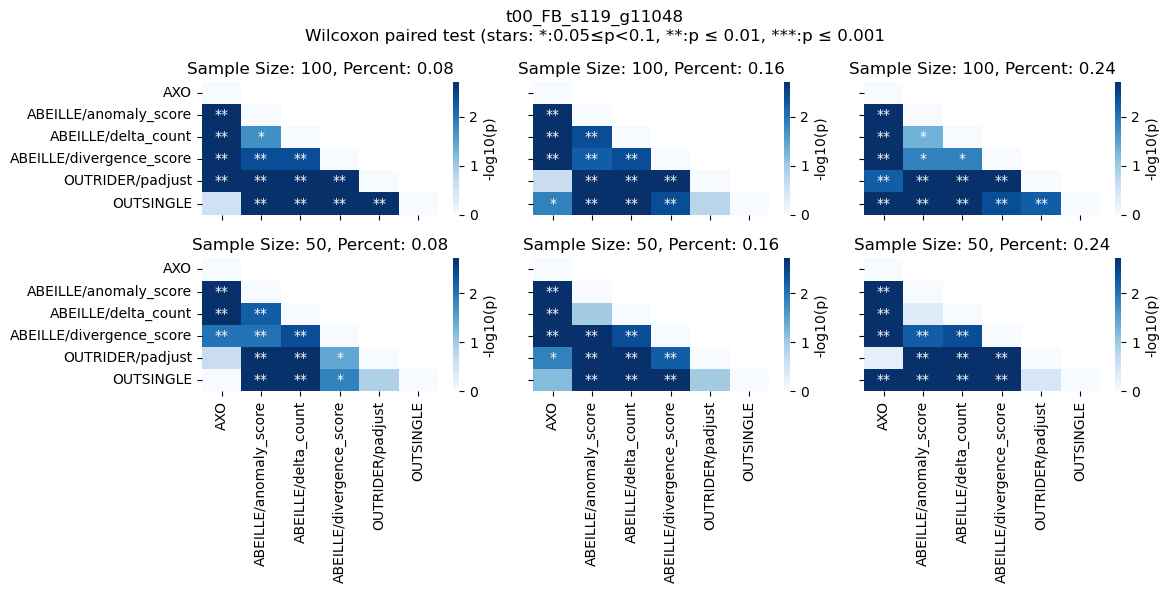

In [152]:
plt.style.use('default')
fig, axes = plt.subplots(len(sample_sizes),len(list_outlier_pct), figsize=(4*len(list_outlier_pct),3*len(sample_sizes)), sharey=True, sharex=True)

for size in sample_sizes:
    for pct in list_outlier_pct:
        auprc = auprc_all_sizes.query('(size == @size) & (pct == @pct)').droplevel(['size','pct'])
        columns = auprc.columns.tolist()
        results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

        for method1, method2 in itertools.combinations(columns, 2):
            x = auprc[method1].dropna()
            y = auprc[method2].dropna()
            
            # make they are same length
            min_len = min(len(x), len(y))
            x = x.iloc[:min_len]
            y = y.iloc[:min_len]
            
            # wilcoxon test
            alternative = 'two-sided'
            stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

            new_row = pd.DataFrame({
                'Method1': [method1],
                'Method2': [method2],
                'Statistic': [stat],
                'p-value': [p_value]
            })
            
            results = pd.concat([results, new_row], ignore_index=True)

        axo_results = results#.query('(Method1 not in @baselines) and (Method2 not in @baselines)')
        # ---- 1. 对称矩阵化 ----
        pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
        pivot = pivot.combine_first(pivot.T)        # 补全下三角
        np.fill_diagonal(pivot.values, 1)           # 对角=1
        
        pivot = pivot.loc[columns, columns] # use the meothds order in auprc
        # ---- 2. -log10 变换 ----
        log_p = -np.log10(pivot)
        log_p = log_p.replace([np.inf, -np.inf], np.nan)

        # ---- 3. 三角掩码 ----
        mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

        def p2star(p):
            if pd.isna(p) or p > 0.05:
                return ''
            elif p <= 1e-4:
                return '****'
            elif p <= 1e-3:
                return '***'
            elif p <= 1e-2:
                return '**'
            else:
                return '*'

        # 1. 星号对称矩阵（同索引）
        star_mat = pivot.applymap(p2star)

        # ---- 4. 画图 ----
        # plt.figure(figsize=(10, 5))
        sns.heatmap(log_p,
                    mask=mask,
                    cmap='Blues',
                    annot=star_mat,
                    fmt='',
                    cbar_kws={'label': '-log10(p)'}, ax=axes[sample_sizes.index(size), list_outlier_pct.index(pct), ])
        # axes[sample_sizes.index(size)].set_xticklabels(axes[sample_sizes.index(size)].get_xticklabels(), rotation=90)
        axes[sample_sizes.index(size),list_outlier_pct.index(pct)].set_title(f'Sample Size: {size}, Percent: {pct}')

plt.suptitle(f'{name_prefix}\nWilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/kremer_heatmap_auprc_sizes50-100_pct_wilcox_p_star.pdf',dpi=200)